<a href="https://colab.research.google.com/github/kaleem500bc/CartPole-DQNAgent-pytorch/blob/main/DQN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
from torch import nn
import gym
import os
from matplotlib import pyplot as plt
import numpy as np
from collections import deque
import random


In [7]:
# make virtual screen and redirect render to this screen
# From https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
!bash ../xvfb start
os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


In [14]:
class Agent:
  def __init__(self,state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = deque(maxlen=2000)
    self.gamma = 0.95
    self.epsilon = 1.0
    self.epsilon_decay = 0.995
    self.epsilon_min = 0.01
    self.learning_rate = 0.001
    self.model = self.create_model()
    self.optimizer = torch.optim.Adam(self.model.parameters())
    self.criterion = nn.MSELoss()

  # Model that will learn the Q-function/ Agent that will play the game
  def create_model(self):
    model = nn.Sequential(
        nn.Linear(self.state_size,256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,self.action_size)
    )
    model.to("cuda")
    return model
    
  # Replay memory where different episode will be store
  def replay_buffer(self, state,action, reward, next_state, done):
    state = torch.tensor(state,dtype=torch.float).to("cuda")
    action = torch.tensor(action,dtype=torch.float).to("cuda")
    reward = torch.tensor(reward,dtype=torch.float).to("cuda")
    next_state = torch.tensor(next_state,dtype=torch.float).to("cuda")
    
    self.memory.append((state,action, reward, next_state,done))
  
  # Get action that the agent should take
  def action(self, state):

    if np.random.rand() <= self.epsilon:
      # Random exploration
      return random.randrange(self.action_size)

    # Get action from the agent/ exploitation
    state = state.to("cuda")
    act_values = self.model(state)
    return int(torch.argmax(act_values).item())


  # Train the model according to q-learning
  def training(self,batch_size, training_iter):
    print("Training Iteration: ", training_iter)
    minibatch = random.sample(self.memory, batch_size)
    for state,action, reward, next_state,done in minibatch:
      actual_reward = reward
      state = state.to("cuda")
      next_state = next_state.to("cuda")

      predicted_reward = self.model(state)
      predicted_reward = predicted_reward[int(action.item())] 
      if not done:
        actual_reward = reward + self.gamma * torch.amax(
            self.model(next_state)
            )
        
        self.optimizer.zero_grad()
    
        loss = self.criterion(predicted_reward,actual_reward)
        loss.backward()
        self.optimizer.step()
      else:
        self.optimizer.zero_grad()
        loss = self.criterion(predicted_reward, actual_reward)
        loss.backward()
        self.optimizer.step()
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay

  





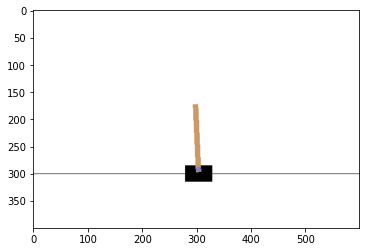

In [15]:
env = gym.make("CartPole-v0").env
obs = env.reset()
plt.imshow(env.render("rgb_array"))

In [16]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = Agent(state_size, action_size)
agent

In [17]:
def populate_replayBuffer(agent,env, n_episode):
  done = False
  batch_size = 2000
  training_iter = 1
  for e in range(n_episode):
    state = env.reset()
    state = torch.tensor(state,dtype=torch.float)
    buffer_size = 5000
    for i in range(buffer_size):
      action = agent.action(state)
      next_state, reward, done, _ = env.step(action)
      reward = reward if not done else -10
      agent.replay_buffer(state,action,reward,next_state,done)
      state = torch.tensor(next_state,dtype=torch.float)

      if done:
        print("episods: {}, score: {}".format(e,i))
        break

    if len(agent.memory) >= batch_size:
      training_iter += 1
      agent.training(batch_size, training_iter)

In [ ]:
populate_replayBuffer(agent,env,5000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


episods: 0, score: 23
episods: 1, score: 17
episods: 2, score: 13
episods: 3, score: 12
episods: 4, score: 17
episods: 5, score: 18
episods: 6, score: 9
episods: 7, score: 15
episods: 8, score: 22
episods: 9, score: 23
episods: 10, score: 17
episods: 11, score: 64
episods: 12, score: 17
episods: 13, score: 12
episods: 14, score: 21
episods: 15, score: 9
episods: 16, score: 14
episods: 17, score: 21
episods: 18, score: 8
episods: 19, score: 18
episods: 20, score: 23
episods: 21, score: 23
episods: 22, score: 10
episods: 23, score: 22
episods: 24, score: 38
episods: 25, score: 39
episods: 26, score: 12
episods: 27, score: 31
episods: 28, score: 14
episods: 29, score: 46
episods: 30, score: 16
episods: 31, score: 25
episods: 32, score: 13
episods: 33, score: 26
episods: 34, score: 17
episods: 35, score: 11
episods: 36, score: 24
episods: 37, score: 17
episods: 38, score: 35
episods: 39, score: 15
episods: 40, score: 17
episods: 41, score: 12
episods: 42, score: 10
episods: 43, score: 40
e